# NbaAnalyse

This project is an analysis of the Nba Database from the [wyattowalsh/nbadb](https://github.com/wyattowalsh/nbadb) project found on [this kaggle page](https://www.kaggle.com/datasets/wyattowalsh/basketball/data).

## Importing Raw Data

We start by importing the raw data into a Dataframe to be able to manage and analyse the data.  
We import the differents files into a table dictionary to easily access the differents Dataframes.

### Importing pandas

In [2]:
import os
import pandas as pd

### Loading files

In [3]:
path = "data/raw/"
files = [path + "common_player_info.csv", path + "draft_combine_stats.csv", path + "draft_combine_stats.csv", path + "draft_combine_stats.csv", path + "draft_history.csv", path + "game.csv", path + "game_info.csv", path + "game_summary.csv", path + "inactive_players.csv", path + "line_score.csv", path + "officials.csv", path + "other_stats.csv", path + "player.csv", path + "team.csv", path + "team_details.csv", path + "team_history.csv", path + "team_info_common.csv"]
table = {}
for file in files:
    filename = os.path.splitext(os.path.basename(file))[0] 
    table[filename] = pd.read_csv(file)

The we can try to print one of the table

In [4]:
print(table['common_player_info'])

      person_id first_name     last_name   display_first_last  \
0         76001       Alaa     Abdelnaby       Alaa Abdelnaby   
1         76003     Kareem  Abdul-Jabbar  Kareem Abdul-Jabbar   
2          1505      Tariq   Abdul-Wahad    Tariq Abdul-Wahad   
3           949    Shareef   Abdur-Rahim  Shareef Abdur-Rahim   
4         76005        Tom     Abernethy        Tom Abernethy   
...         ...        ...           ...                  ...   
4166    1627835       Paul        Zipser          Paul Zipser   
4167    1627790       Ante         Zizic           Ante Zizic   
4168      78647        Jim          Zoet             Jim Zoet   
4169    1627826      Ivica         Zubac          Ivica Zubac   
4170      78650       Matt         Zunic           Matt Zunic   

     display_last_comma_first  display_fi_last          player_slug  \
0             Abdelnaby, Alaa     A. Abdelnaby       alaa-abdelnaby   
1        Abdul-Jabbar, Kareem  K. Abdul-Jabbar  kareem-abdul-jabbar   
2     

In [5]:
# print the columns of a specific table
print("team_history :",table["team_history"].columns)

team_history : Index(['team_id', 'city', 'nickname', 'year_founded', 'year_active_till'], dtype='object')


## Analysing and displaying the data

### Import matplotlib

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

### Number of inactive players by team

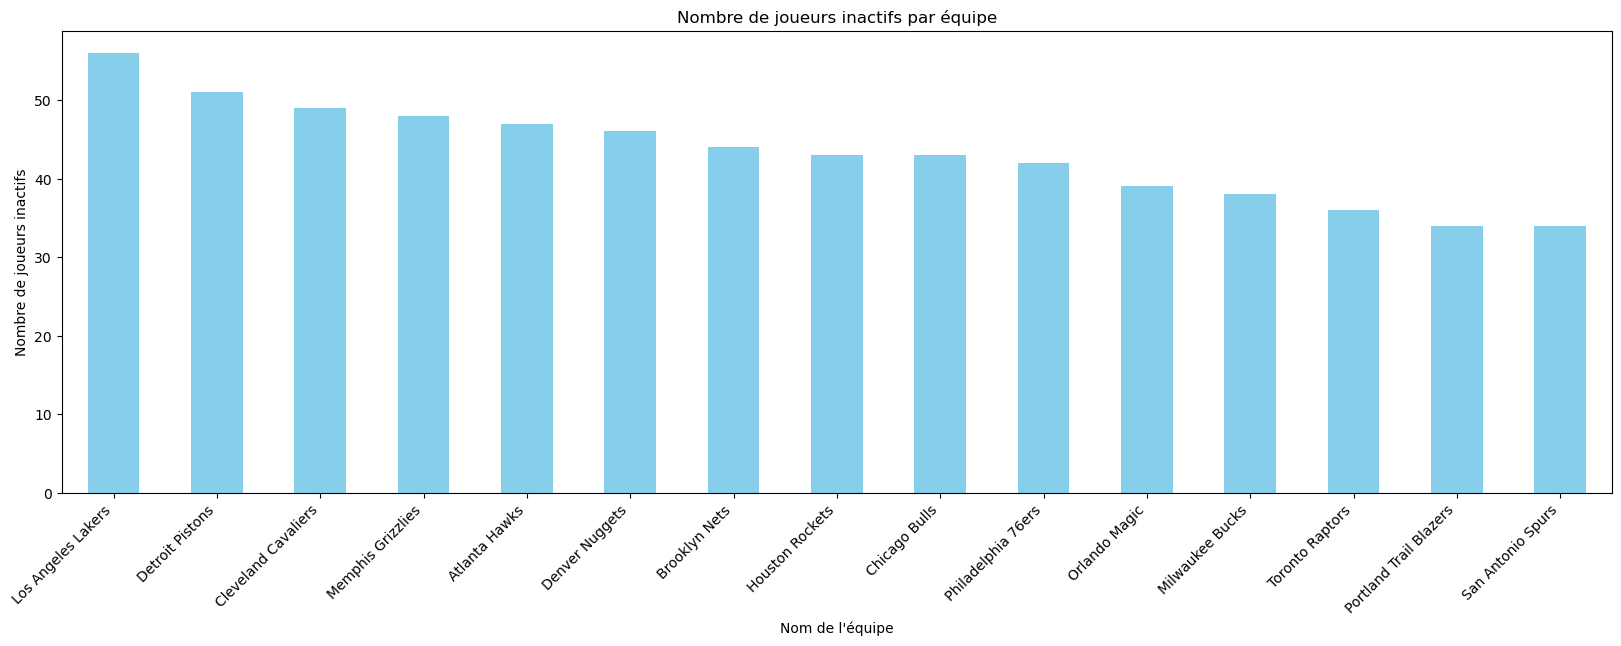

In [7]:
inactive_id = table['inactive_players']['player_id']
cpi = table['common_player_info']
inactive_team_ids = cpi[cpi['person_id'].isin(inactive_id) & cpi['team_id'] != 0]['team_id']
team_counts = inactive_team_ids.value_counts()
team_mapping = table['team'].set_index('id')['full_name']
team_counts.index = team_counts.index.map(team_mapping)
team_counts.fillna(0).plot(kind='bar', figsize=(20, 6), color='skyblue', title='Nombre de joueurs inactifs par équipe')
plt.xlabel('Nom de l\'équipe')
plt.ylabel('Nombre de joueurs inactifs')
plt.xticks(rotation=45, ha='right')  
plt.show()

### Number of points scored by the teams at home and away

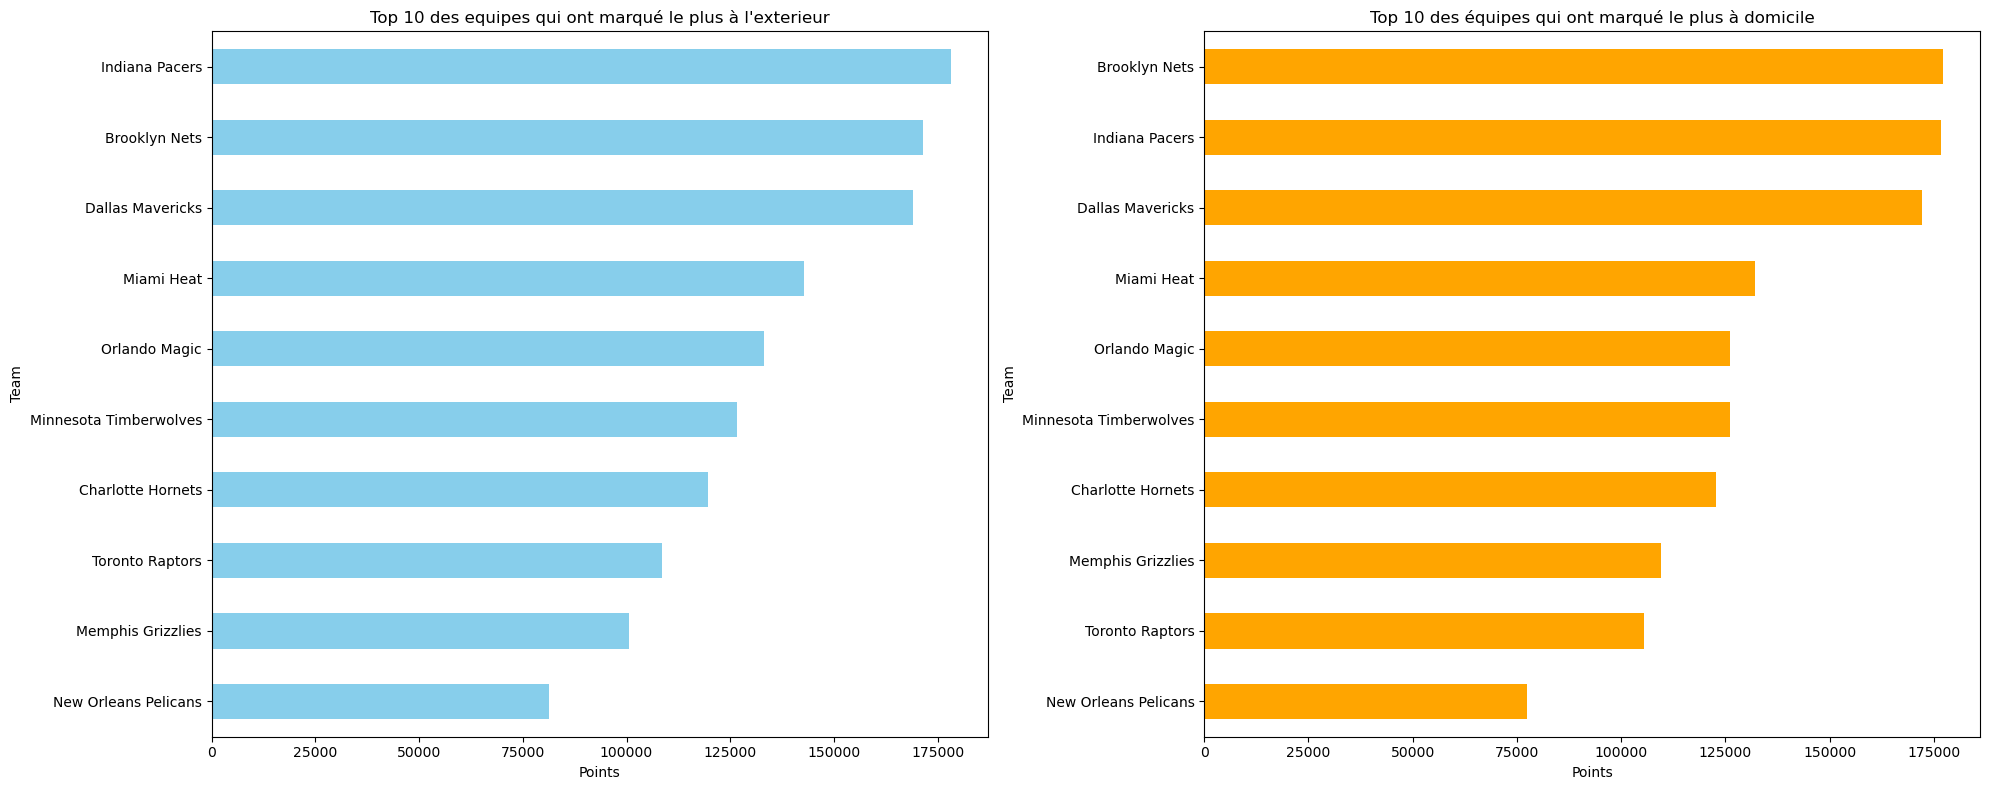

In [8]:
equipe_score_home = table['line_score'][['team_id_home', 'pts_home']].groupby("team_id_home").sum()
equipe_score_away = table['line_score'][['team_id_away', 'pts_away']].groupby("team_id_away").sum()

teams = table['team']
equipe_score_home = equipe_score_home.merge(teams, left_on="team_id_home", right_on="id")
equipe_score_away = equipe_score_away.merge(teams, left_on="team_id_away", right_on="id")

best_score_home = equipe_score_home.sort_values("pts_home", ascending=True).head(10)
best_score_away = equipe_score_away.sort_values("pts_away", ascending=True).head(10)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

best_score_away.plot(
    kind="barh",
    x="full_name",  
    y="pts_away",
    ax=ax[0],
    color="skyblue",
    legend=False
)
ax[0].set_title("Top 10 des equipes qui ont marqué le plus à l'exterieur")
ax[0].set_xlabel("Points")
ax[0].set_ylabel("Team")


best_score_home.plot(
    kind="barh",
    x="full_name",  
    y="pts_home",
    ax=ax[1],
    color="orange",
    legend=False
)
ax[1].set_title("Top 10 des équipes qui ont marqué le plus à domicile")
ax[1].set_xlabel("Points")
ax[1].set_ylabel("Team")

# Show the plot
plt.tight_layout()
plt.show()


### Total Number of points scored by the teams

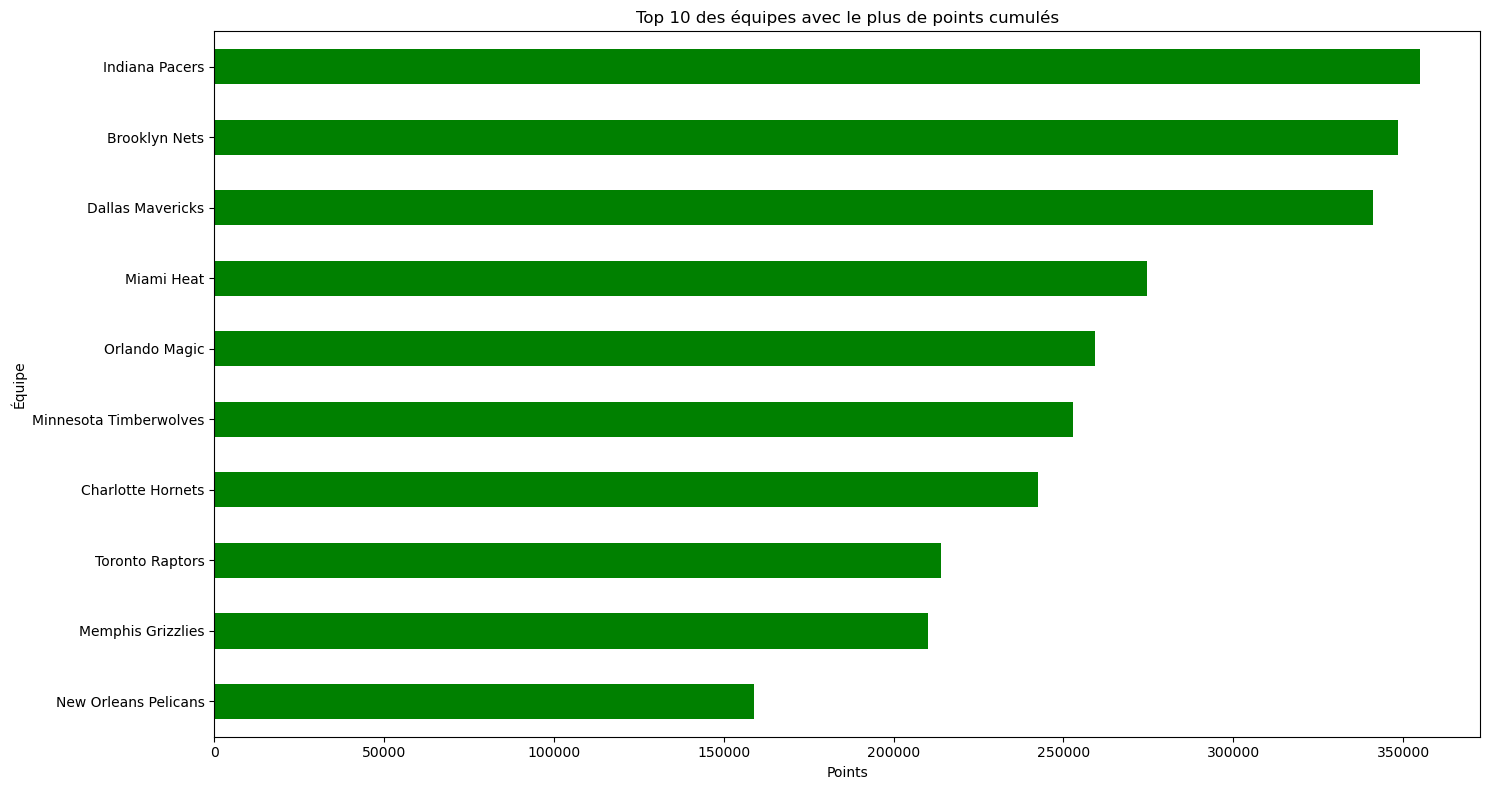

In [9]:
equipe_score_home = table['line_score'][['team_id_home', 'pts_home']].groupby("team_id_home").sum().reset_index()
equipe_score_away = table['line_score'][['team_id_away', 'pts_away']].groupby("team_id_away").sum().reset_index()

teams = table['team']
equipe_score_home = equipe_score_home.merge(teams, left_on="team_id_home", right_on="id")
equipe_score_away = equipe_score_away.merge(teams, left_on="team_id_away", right_on="id")

equipe_score_home = equipe_score_home.rename(columns={"pts_home": "pts", "team_id_home": "team_id"})
equipe_score_away = equipe_score_away.rename(columns={"pts_away": "pts", "team_id_away": "team_id"})

equipe_score_total = pd.concat([equipe_score_home[['team_id', 'pts', 'full_name']], 
                                 equipe_score_away[['team_id', 'pts', 'full_name']]])

equipe_score_total = equipe_score_total.groupby(["team_id", "full_name"]).sum().reset_index()

best_score_total = equipe_score_total.sort_values("pts", ascending=True).head(10)

fig, ax = plt.subplots(figsize=(15, 8))
best_score_total.plot(
    kind="barh",
    x="full_name",
    y="pts",
    ax=ax,
    color="green",
    legend=False
)
ax.set_title("Top 10 des équipes avec le plus de points cumulés")
ax.set_xlabel("Points")
ax.set_ylabel("Équipe")

plt.tight_layout()
plt.show()


### Import NumPy

In [10]:
import numpy as np

### Top teams by number of victories

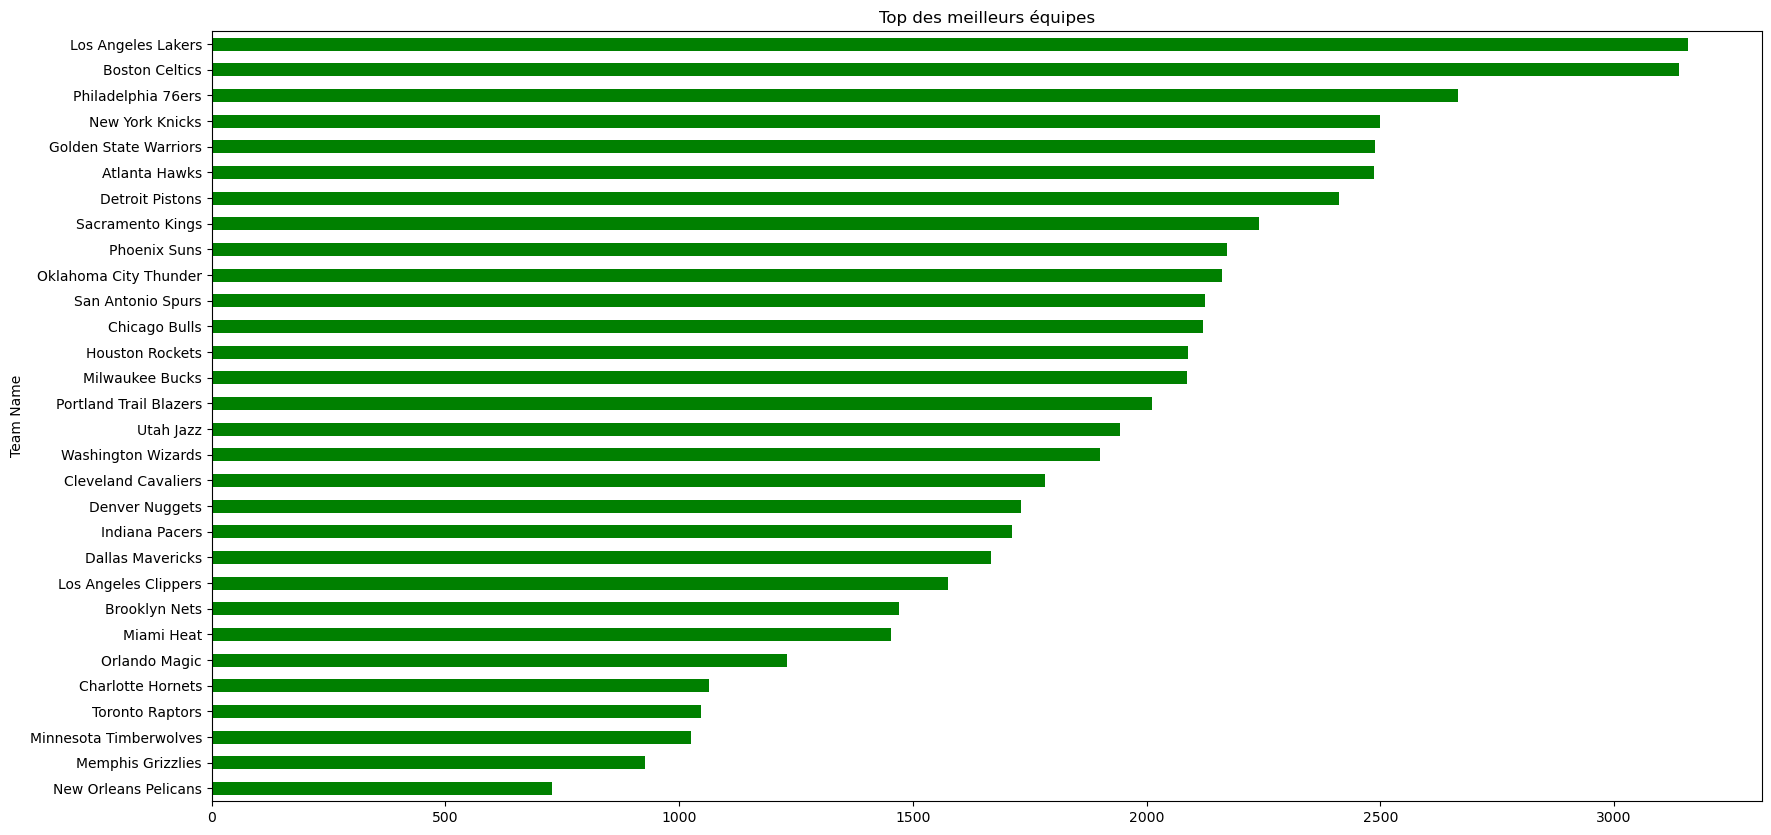

In [11]:
table['line_score']['victor'] = np.where(
    table['line_score']['pts_home'] > table['line_score']['pts_away'],
    table['line_score']['team_id_home'],
    np.where(
        table['line_score']['pts_home'] < table['line_score']['pts_away'],
        table['line_score']['team_id_away'],
        None
    )
)

# print(table['line_score'][['game_id', 'team_id_home', 'pts_home', 'team_id_away', 'pts_away', 'victor']].head())

victor_counts = table["line_score"]["victor"].value_counts().reset_index()
victor_counts.columns = ['team_id', 'victories']

victor_counts_with_names = victor_counts.merge(
    table["team"],
    left_on='team_id',
    right_on='id',
    how='left'
)
victor_counts_with_names = victor_counts_with_names[['team_id', 'victories', 'full_name']]
# victor_counts_with_names.dropna(axis=1, subset="full_name")

victor_counts_with_names = victor_counts_with_names.dropna(subset="full_name").sort_values("victories")
victor_counts_with_names[['full_name', 'victories']].plot(
    kind="barh",
    x="full_name",
    y="victories",
    ylabel="Team Name",
    title="Top des meilleurs équipes",
    color="green",
    legend=False,
    figsize=(20, 10)
)
plt.show()

### Number of founded teams per year

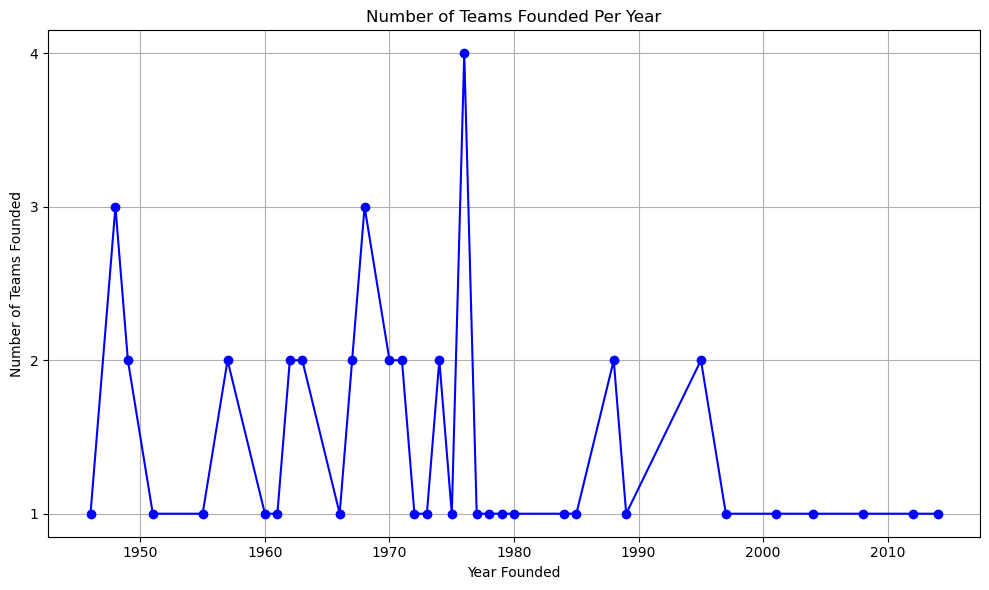

In [12]:
teams_by_year = table['team_history'].groupby('year_founded').size()

teams_by_year.plot(kind="line", figsize=(10, 6), color="blue", marker="o")

plt.xlabel("Year Founded")
plt.ylabel("Number of Teams Founded")
plt.title("Number of Teams Founded Per Year")
plt.grid(True)

plt.yticks(np.arange(teams_by_year.min(), teams_by_year.max() + 1, 1))

plt.tight_layout()
plt.show()

# print(teams_by_year.sort_values(ascending=False))

### Number of teams that where active untill a specific year

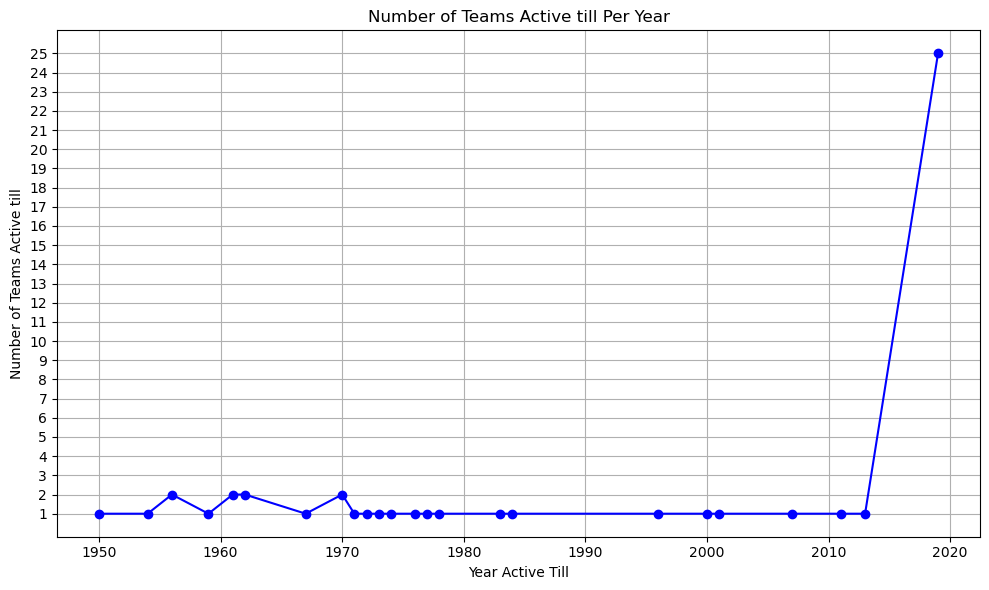

In [13]:
teams_by_year = table['team_history'].groupby('year_active_till').size()

teams_by_year.plot(kind="line", figsize=(10, 6), color="blue", marker="o")

plt.xlabel("Year Active Till")

plt.ylabel("Number of Teams Active till")
plt.title("Number of Teams Active till Per Year")
plt.grid(True)

plt.yticks(np.arange(teams_by_year.min(), teams_by_year.max() + 1, 1))

plt.tight_layout()
plt.show()


### Top 10 organizations with the most players

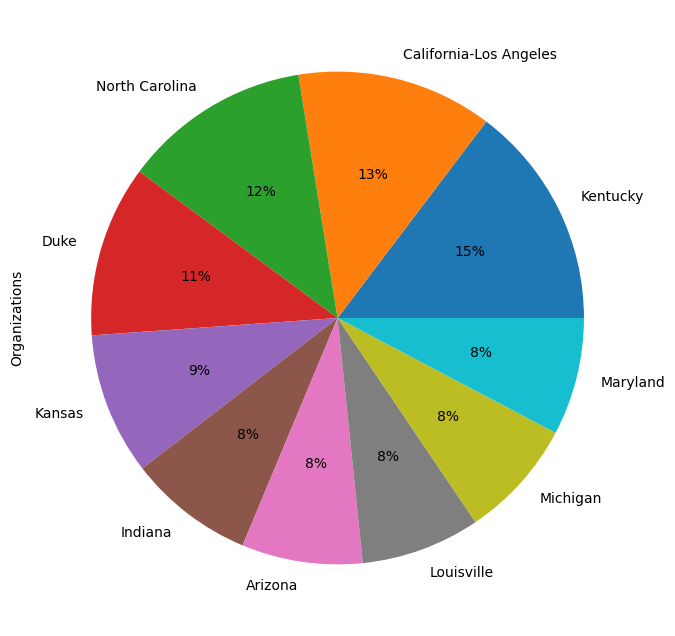

In [14]:
dh : pd.DataFrame = table['draft_history']
organization_player : pd.DataFrame = dh['organization']
top10 = organization_player.value_counts().head(10)
# gt20 = np.where(top10["count"] > 20, top10["count"], None)
# other_count = organization_player.value_counts().sum() - top10.sum()
# all = pd.Series(top10)
# all.loc["Other"] = other_count
# print(all)
# gt20.plot(kind="barh", figsize=(20, 8))
top10.plot(kind="pie", autopct='%1.0f%%', figsize=(20, 8), ylabel="Organizations")
plt.show()

### Number of teams per league division

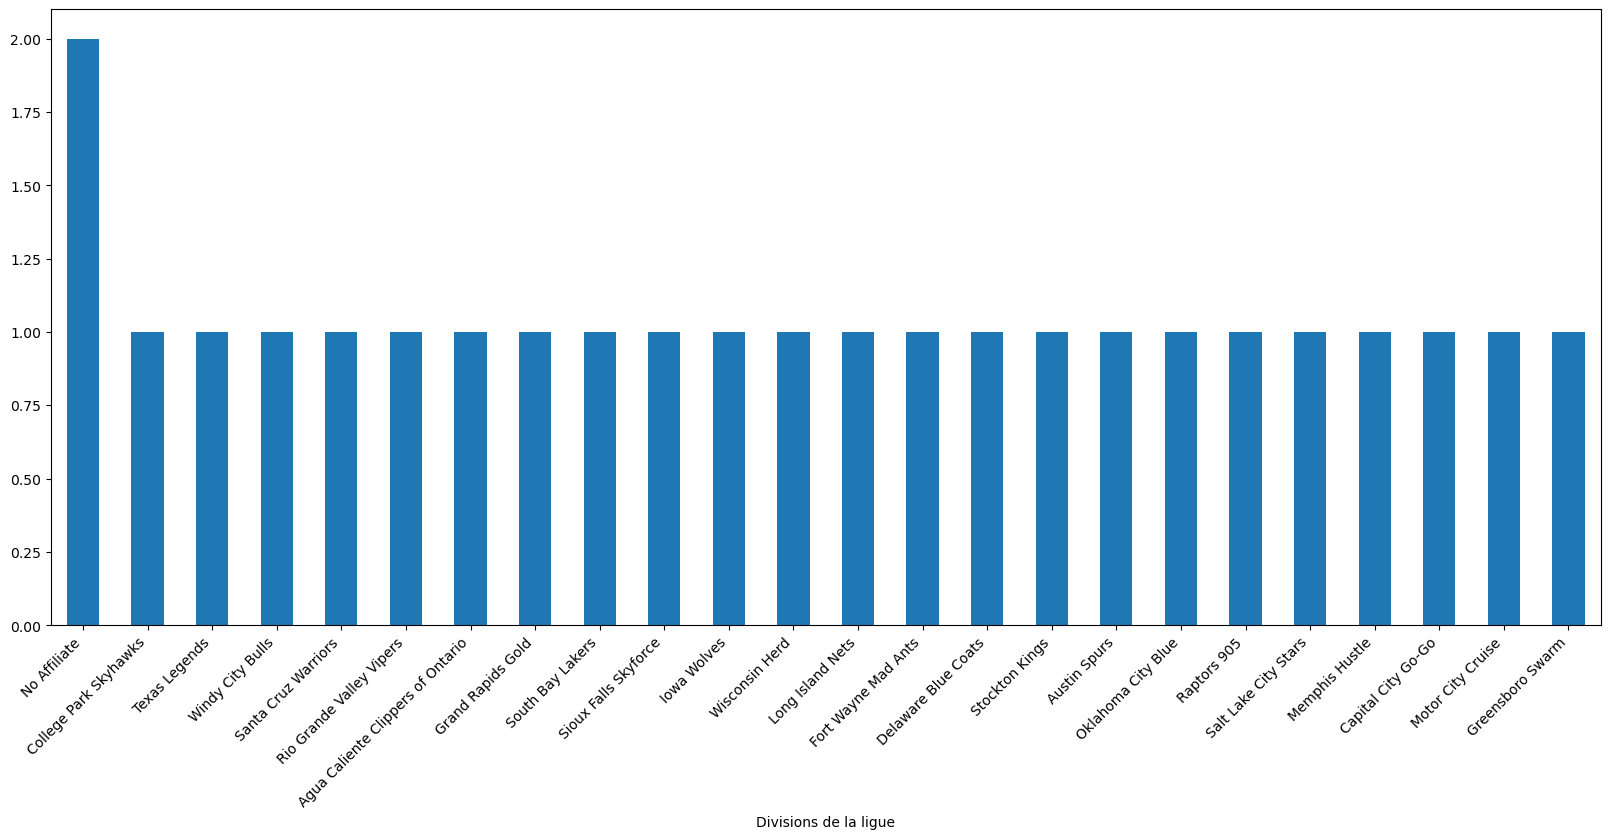

In [15]:
league = table['team_details']['dleagueaffiliation'].value_counts()

league.plot(kind='bar', figsize=(20, 8), xlabel="Divisions de la ligue")
plt.xticks(rotation=45, ha='right')
plt.show()

### Number of Player Born Per Year

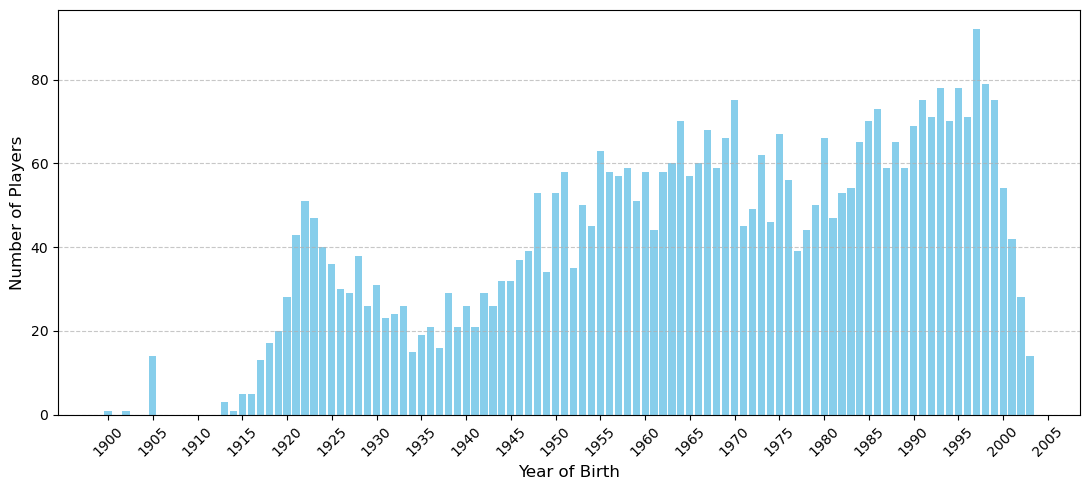

In [21]:
data = table["common_player_info"]
# Convert 'birthdate' to datetime format
data['birthdate'] = pd.to_datetime(data['birthdate'])

# Extract birth year
data['birth_year'] = data['birthdate'].dt.year

# Count the number of players born per year
birth_year_counts = data['birth_year'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(11, 5))
plt.bar(birth_year_counts.index, birth_year_counts.values, color='skyblue')
plt.xlabel('Year of Birth', fontsize=12)
plt.ylabel('Number of Players', fontsize=12)
# plt.title('Number of Players Born Per Year', fontsize=14)
# plt.xticks(birth_year_counts.index, rotation=45)
plt.xticks(np.arange(birth_year_counts.index.min(), birth_year_counts.index.max() + 5, 5),rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()